# **MIT5672_Lab2_EthanRichards**

# Tackle the California housing dataset

The goal is to use ridge, lasso, elastic net, and sgd_regressor (with early stopping) to train four regulized regression models to predict housing prices in California. Then you choose the best model based on RMSE.

Please note that the data contains information from the 1990 California census. So it may not help you with predicting current housing prices like the Zillow Zestimate dataset.

Let's fetch the data and load it:

In [ ]:
import numpy as np
from sklearn.datasets import fetch_california_housing

# Load the California Housing dataset
data = fetch_california_housing(as_frame=True)

type(data)


sklearn.utils._bunch.Bunch

In [ ]:
list(data)

['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR']

In [ ]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Let's first conduct exploratory data analysis (EDA) to understand the dataset better.

#### **Q1: Convert data.data as dataframe and show the top few rows of the training set**

In [ ]:
import pandas as pd

df = data.data

# why does this work??? data.data??

# type(df)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


#### **Q2: Add target to the dataframe and show basic information, e.g. the index dtype and columns, non-null values and memory usage.**

In [ ]:
df.info()
df["MedHouseVal"] = data.target

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


#### **Q3: Use a method which returns description of the data in the DataFrame, e.g. count, mean, std, min, 25%, 50%, 75%, max.**

In [ ]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


#### **Q4: Create correlation matrix to understand relationships between features and target**

In [ ]:
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


#### **Q5: Visualize correlations using a heatmap**

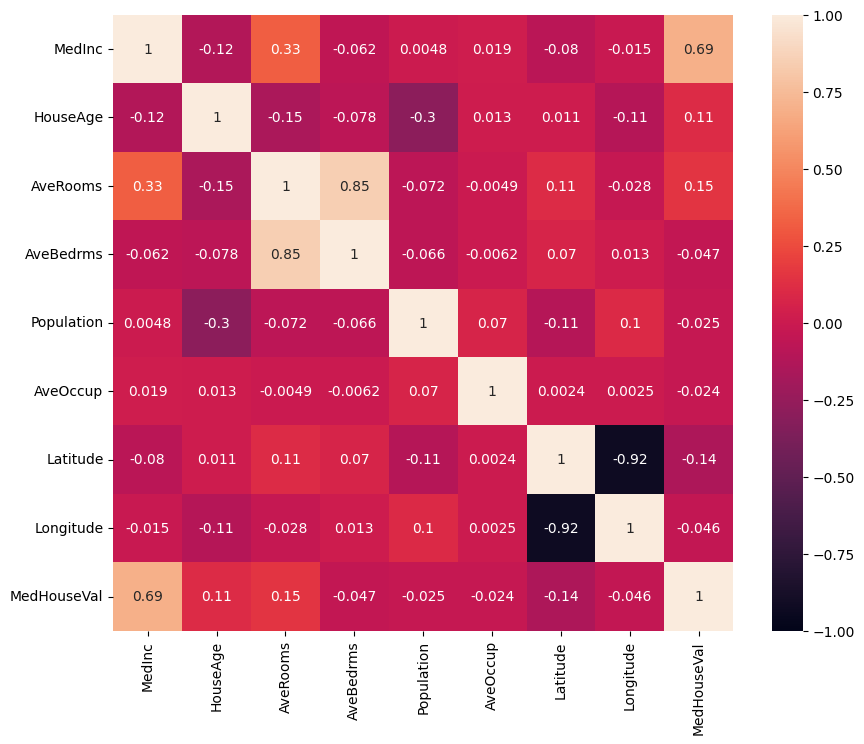

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,8))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1,annot = True)

# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

plt.show()

After conducting EDA, let's move to the modeling part.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import StandardScaler

X, y = data.data, data.target

#### **Q6: Split data into training and test sets**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)

# X_train.shape
# y_test.shape

X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


#### **Q7: Scaling the features for all the models**

In [ ]:
from sklearn.preprocessing import StandardScaler

StdScaler = StandardScaler()

StdScaler.fit(X_train)

X_train_scaled = StdScaler.transform(X_train)

X_test_scaled = StdScaler.transform(X_test)

####    **Q8: Initialize four models: ridge, lasso, elastic net, and sgd_regressor (with early stopping)**

In [ ]:
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X_train_scaled, y_train)

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_scaled, y_train)

#sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / 20, tol=None,
                       #max_iter=1000, eta0=0.01, random_state=42)
#sgd_reg.fit(X_train_scaled, y_train.ravel())  # y.ravel() because fit() expects 1D targets

SGDRegressor(alpha=0.005, random_state=42, tol=None)

#### **Q9: Train four models: ridge, lasso, elastic net, and sgd_regressor (with early stopping)**

In [ ]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / 20, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42, early_stopping=True)
sgd_reg.fit(X_train_scaled, y_train.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict(X_train_scaled)

# same as before but added early stopping

array([1.04131869, 3.80410338, 1.73691758, ..., 2.21839555, 2.83489014,
       3.23723784])

#### **Q10: Use those four models to make predictions**

In [ ]:
y_pred_ridge = ridge_reg.predict(X_test_scaled)
y_pred_lasso = lasso_reg.predict(X_test_scaled)
y_pred_en = elastic_net.predict(X_test_scaled)
y_pred_sgd = sgd_reg.predict(X_test_scaled)

#### **Q11: Calculate mean squared error (RMSE) for each model**

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# NOTE mean_squared_error only gives you MSE, you must use np.sqrt() to get RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
en_rmse = np.sqrt(mean_squared_error(y_test, y_pred_en))
sgd_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sgd))

#### **Q12: Print the RMSEs of each model and choose the best model**

In [ ]:
print(ridge_rmse)
print(lasso_rmse)
print(en_rmse)
print(sgd_rmse)



1.1653599134875345e-05
0.09901963469086623
0.1042032135073638
0.009391834280748633


#### **Q13: Click Share at the top right. Ensure sharing settings are set to "Anyone with the link can edit." Copy the shared link. Submit this link to the Canvas assignment page.**